In [1]:
import numpy as np
from astropy.coordinates import SkyCoord, HeliocentricTrueEcliptic, ITRS, EarthLocation
import torch as tn
from time import sleep
from datetime import datetime, timedelta, timezone

In [2]:
CL = tn.tensor([
    [0, 0, 0, 0],
    [0, 1e-5, 0, 0],
    [0, 0, 1e-5, 0],
    [0, 0, 0, 1e-5]
], dtype=tn.float32)

CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

p1 = 1 / np.sqrt(2) * tn.tensor([1,0, 0,1], dtype=tn.float32)

p2 = 1 / np.sqrt(2) * tn.tensor([1,0, 0,-1], dtype=tn.float32)

In [3]:

tn.set_printoptions(precision=10, sci_mode=False)


# Define the location of CMS in terms of longitude, latitude and azimuth

azimuth = 1.7677    
latitude = 0.8082  
longitude = 0.1061   

# Define the Earth's angular velocity (rad/s)
omega_utc = 7.27221e-5     # Earth's angular velocity in rad/s at UTC.


# omega_t = omega_utc*time + 3.2830    #omeag*t = omega_UTC * t_CMS +phi_UNIX +phi_longit

# Rotation matrices to go from ITRS to CMS frame

# rotation around the z-axis which makes the x-axis normal to the plane of the LHC.

R_z = tn.tensor([
        [1,0,0,0],
        [0,0,-1,0],
        [0,1,0,0],
        [0,0,0,1]
    ], dtype=tn.float32)


# To orient the z-axis towards the North. We rotate counterclockwise around the x′ axis with an angle π −θ (co-azimuth).
def R_x(angle):
    return tn.tensor([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, - np.cos(angle), np.sin(angle)],
        [0, 0, - np.sin(angle), - np.cos(angle)]
    ], dtype=tn.float32)


# Rotation around the y axis to align the z-axis with the Z-axis of the SCF.
def R_y(angle):
    return tn.tensor([
        [1, 0, 0, 0],
        [0, np.cos(angle), 0, np.sin(angle)],
        [0, 0, 1, 0],
        [0, -np.sin(angle), 0, np.cos(angle)]
    ], dtype=tn.float32)


# A final rotation around the Z-axis has two purposes: to follow the rotation of the Earth over time and to synchronize with the SCF:
def R_Z(angle):
    return tn.tensor([
        [1, 0 , 0, 0],
        [0, np.cos(angle), -np.sin(angle), 0],
        [0, np.sin(angle), np.cos(angle), 0],
        [0, 0, 0, 1]
    ], dtype=tn.float32)


## test

In [5]:
# # Define the time duration (60 seconds)
# duration = 60
# end_time = datetime.now(timezone.utc).timestamp() + duration

# while datetime.now(timezone.utc).timestamp() < end_time:
#     # current time in UTC (CMS)
#     current_time = datetime.now(timezone.utc)
#     time_utc = current_time.timestamp()
    
#     # Calculate omega_t
#     omega_t = omega_utc * time_utc + 3.2830  # omega*t = omega_UTC * t_CMS + phi_UNIX + phi_longit

#     # Construct the complete rotation matrix from SCF to CMS
#     R_matrix = R_y(latitude) @ R_x(azimuth) @ R_z @ R_Z(omega_t)
#     contr = tn.matmul(CL, R_matrix)
#     result = tn.dot(p1, tn.mv(contr, p2))

#     # Print the rotation matrix and flush the output
#     print(R_matrix)
#     print(result)
#     print(flush=True)
    
#     # Wait for 4 seconds
#     sleep(4)

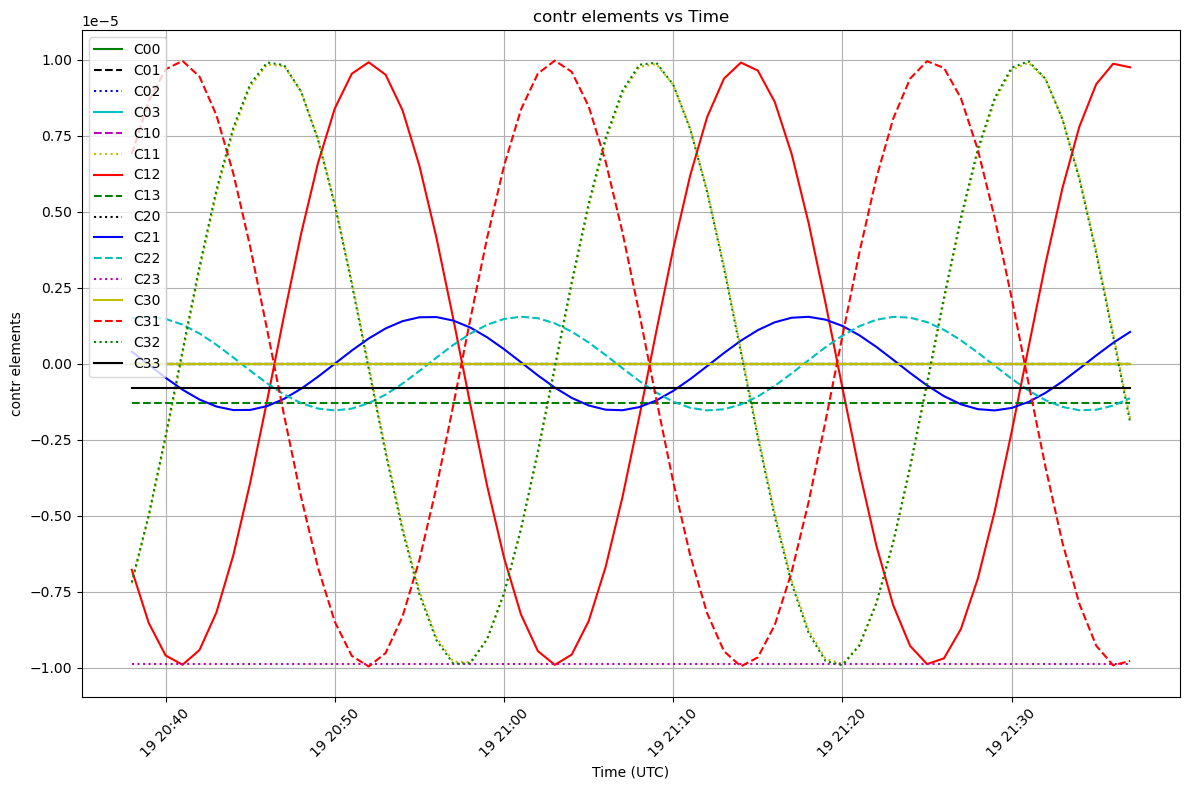

In [41]:

# Initialize the variables
start_time = datetime.now(timezone.utc).replace(microsecond=0, second=0)  # Start from the beginning of the current hour
end_time = start_time + timedelta(hours=1)
step = timedelta(minutes=1)  # Step of 1 minute

# Lists to store the times and contr matrix elements
times = []
contr_elements = []

current_time = start_time
while current_time < end_time:
    time_utc = current_time.timestamp()
    
    # Calculate omega_t
    omega_t = omega_utc * time_utc + 3.2830  # omega*t = omega_UTC * t_CMS + phi_UNIX + phi_longit

    # Construct the complete rotation matrix from SCF to CMS
    R_matrix = R_y(latitude) @ R_x(azimuth) @ R_z @ R_Z(omega_t)
    contr = np.matmul(CL, R_matrix)
    result = np.dot(p1, np.dot(contr, p2))

    # Record the times and contr matrix elements
    times.append(current_time)
    contr_elements.append(contr.flatten())  # Flatten the matrix to store its elements in a list
    
    # Move to the next minute
    current_time += step

# Convert the list of contr elements to a NumPy array for easier indexing
contr_elements = np.array(contr_elements)

# Function to generate labels
def generate_label(index):
    row = index // 4 
    col = index % 4
    return f'C{row}{col}'



colors = ['g', 'k', 'b', 'c', 'm', 'y', 'r']
line_styles = ['-', '--', ':']
num_styles = len(colors) * len(line_styles)

# Plotting all elements of the contr matrix vs time
plt.figure(figsize=(12, 8))
num_elements = contr_elements.shape[1]
for i in range(num_elements):
    color = colors[i % len(colors)]
    line_style = line_styles[i % len(line_styles)]
    plt.plot(times, contr_elements[:, i], color + line_style, label=generate_label(i))

plt.xlabel('Time (UTC)')
plt.ylabel('contr elements')
plt.title('contr elements vs Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

